In [1]:
import numpy as np
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import data.madx_runner as mr
import os
import data.madxconfigurationgenerator as mc
import ROOT
from ROOT import gSystem, gInterpreter
import approximator.particles_trajectory_generator as ptg
home = "/home/rafalmucha/Pobrane/optic/"
path_to_project = home+"/optics_generator_python"
path_to_file = home+"/s/parametrization_6500GeV_0p4_185_reco_b1.root"
"""
Get approximator from file. Use only once, since it initialize variables in ROOT, so with second use it is going
to explode. Sorry.
:param path_to_project: path to optics_generator_python. Needed files from it:
- properly initialized folder root_libs
- src/root_classes/include
:param path_to_file: path to file with serialized LHCOpticsApproximator object
:return: approximator object
"""
os.environ['LD_LIBRARY_PATH'] = path_to_project + "/root_libs"
gInterpreter.ProcessLine(".include " + path_to_project + "/src/root_classes/include")
gSystem.Load("LHCOpticsApproximator")
gInterpreter.ProcessLine('TFile *f=TFile::Open("' + path_to_file + '");')
gInterpreter.ProcessLine('std::auto_ptr<LHCOpticsApproximator> apr_near150 = std::auto_ptr<LHCOpticsApproximator>((LHCOpticsApproximator*) f->Get("ip5_to_station_220_h_1_lhcb1"));')
gInterpreter.ProcessLine("f->Close()")
gInterpreter.ProcessLine("double input[6];")
gInterpreter.ProcessLine("double output[5];")
aperture = ROOT.apr_near150
approximator = aperture

Welcome to JupyROOT 6.16/00


In [2]:
# Parameters of bunch
x_mean = 0.0
sigma_x = 0.00002
theta_x_mean = 0.000
sigma_theta_x = 0.000003
y_mean = 0.0
sigma_y = 0.00002
theta_y_mean = 0.00
sigma_theta_y = 0.000003
t_mean = 0
sigma_t = 0
pt_mean = 0
sigma_pt = 0

In [3]:
configuration = {}

configuration["x_min"] = x_mean - sigma_x
configuration["x_max"] = x_mean + sigma_x
configuration["y_min"] = y_mean - sigma_y
configuration["y_max"] = y_mean + sigma_y
configuration["t_min"] = t_mean - sigma_t
configuration["t_max"] = t_mean + sigma_t

configuration["theta_x_min"] = theta_x_mean - sigma_theta_x
configuration["theta_x_max"] = theta_x_mean + sigma_theta_x
configuration["theta_y_min"] = theta_y_mean - sigma_theta_y
configuration["theta_y_max"] = theta_y_mean + sigma_theta_y
configuration["pt_min"] = pt_mean - sigma_pt
configuration["pt_max"] = pt_mean + sigma_pt

In [4]:
x_angle_min = 0.0000
x_angle_max = 0.0000
y_angle_min = 0.0000
y_angle_max = 0.000

number_of_particles_in_one_run = 2000
target = number_of_particles_in_one_run

output = ptg.generate_random_particles(configuration, {"x_min": x_angle_min, "x_max": x_angle_max, "y_min": y_angle_min, "y_max": y_angle_max}, approximator, target, number_of_particles_in_one_run)

2000


In [5]:
output["start"]

array([[-1.48613513e-05, -2.70909387e-06, -1.74470333e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.39397856e-05,  1.83074884e-08, -1.66363392e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.49051546e-05,  1.41652150e-06,  8.16940687e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-8.24336847e-06,  1.87811882e-08, -7.44652904e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.23330350e-05, -1.36765258e-06,  1.91026181e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.70120920e-05,  5.14415530e-08, -1.73841000e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [6]:
# Names of segments, like MQXA.3R5
start_segment_name = "start"
end_segment_name = "end"

if start_segment_name != "start":
    output[start_segment_name].T[1] -= 1

In [7]:
output_matrix = output[end_segment_name]
input_matrix = output[start_segment_name]

In [8]:
index_map = {
    "x": 0,
    "theta x": 1,
    "y": 2,
    "theta y": 3,
    "t": 4,
    "pt": 5,
    "alfa x": 6,
    "alfa y": 7
}
meters = " [m]"
radians = " [rad]"
seconds = " [s]"
energy = " [TeV]"
no_unit = " "
unit_map = {
    "x": meters,
    "theta x": radians,
    "y": meters,
    "theta y": radians,
    "t": seconds,
    "pt": no_unit,
    "s": meters,
    "e": energy,
    "alfa x": radians,
    "alfa y": radians
}


def plot_histogram(x_name, y_name, x_name_prefix, y_name_prefix, x_matrix, y_matrix, plot_axes, plot_x_pos, plot_y_pos):
    
    title = "Histogram " + x_name_prefix + x_name + " and " + y_name_prefix + y_name + " parameter"
    
    # Get vectors and their properties
    
    x_index = index_map[x_name]
    y_index = index_map[y_name]
    
    vector_x = pd.Series(x_matrix.T[x_index], name=x_name_prefix + x_name)
    vector_y = pd.Series(y_matrix.T[y_index], name=y_name_prefix + y_name)
    
    print(np.min(vector_x), np.max(vector_x))
    
    bins_number = 12
    
    sns.distplot(vector_x, bins=bins_number, ax=axes[plot_x_pos][plot_y_pos], color='y').set_title(title)
    sns.distplot(vector_y, bins=bins_number, ax=axes[plot_x_pos][plot_y_pos], color='b').set_title(title)

-1.9999641564760152e-05 1.997513363093168e-05
-1.996632818986025e-05 1.9987070340195596e-05
-2.9895325265790368e-06 2.998278301126238e-06
-2.997156230762948e-06 2.999132555302745e-06


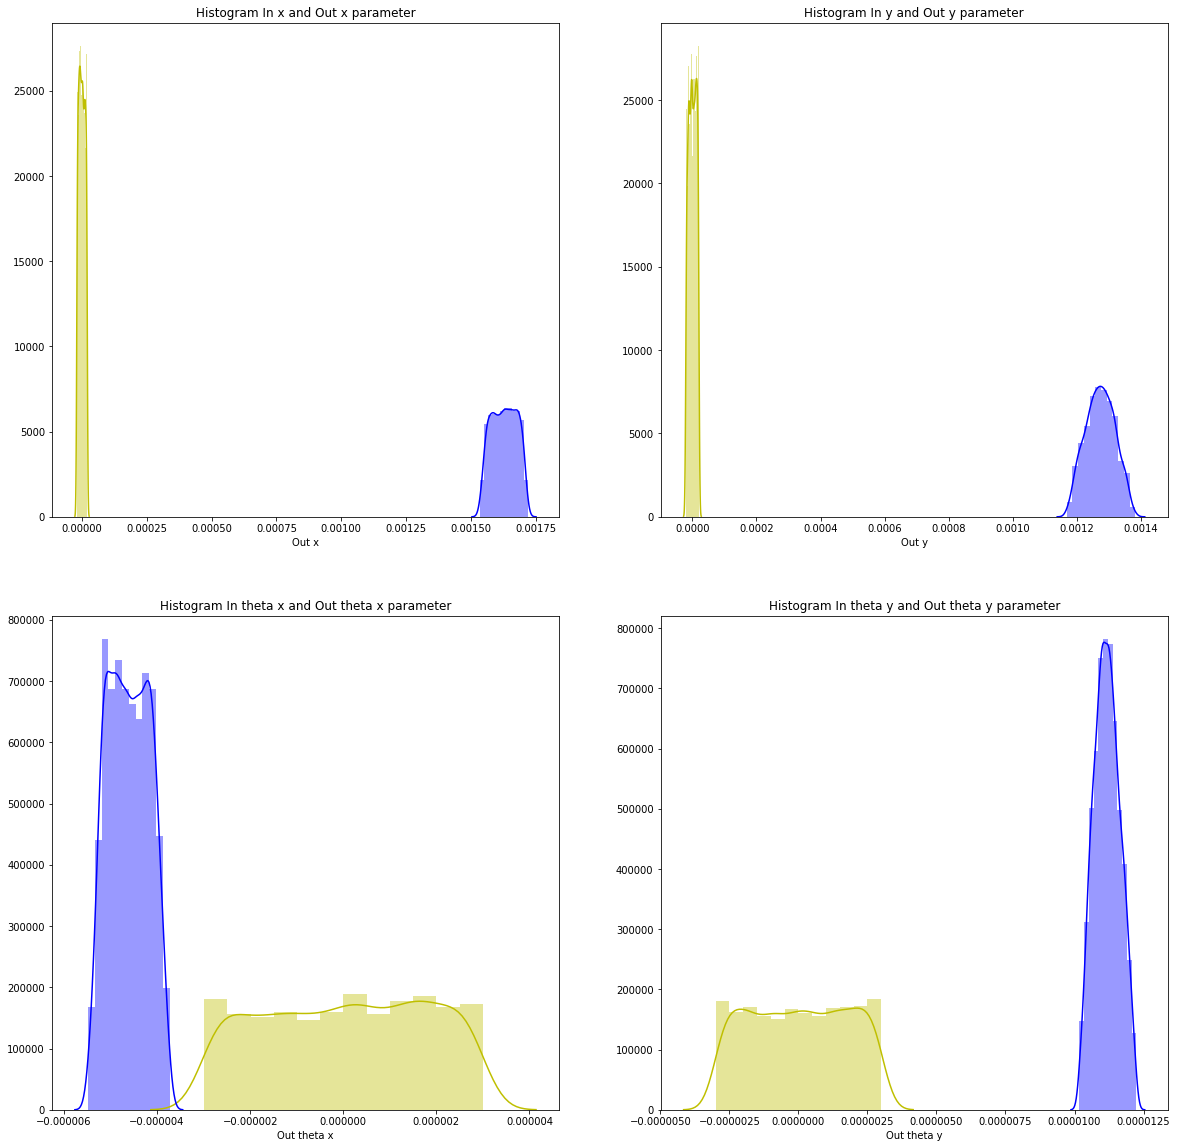

In [9]:
f, axes = plt.subplots(2, 2)

fig = plt.gcf()
fig.set_size_inches(20,20)

plot_histogram("x", "x", "In ", "Out ", input_matrix, output_matrix, axes, 0, 0)

plot_histogram("y", "y", "In ", "Out ", input_matrix, output_matrix, axes, 0, 1)

plot_histogram("theta x", "theta x", "In ", "Out ", input_matrix, output_matrix, axes, 1, 0)

plot_histogram("theta y", "theta y", "In ", "Out ", input_matrix, output_matrix, axes, 1, 1)
